# 02: Data Augmentation & Train/Val/Test Split

## Objective
This notebook performs:
1. **Stratified Train/Val/Test Split** (70/15/15) preserving both pathology category and FST (V vs VI) distributions
2. **Targeted Augmentation** for minority classes in the training set only
3. **Quality Validation** to ensure clinical realism and no data leakage

## Context
- Total images: 2,155 (FST V–VI from Fitzpatrick17k)
- Categories: 9 pathology classes (all retained)
- Augmentation strategy: Generated dynamically based on training split
- Target: Reduce imbalance without enforcing full class parity

In [9]:
# Import required libraries
import os
import json
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"Random seed set to: {RANDOM_SEED}")
print("Libraries imported successfully!")

Random seed set to: 42
Libraries imported successfully!


## 1. Configuration & Paths

In [10]:
# Define paths
BASE_DIR = Path('../')
DATA_RAW_DIR = BASE_DIR / 'data' / 'raw' / 'fitzpatrick17k'
IMAGES_DIR = DATA_RAW_DIR / 'images'
METADATA_FILE = DATA_RAW_DIR / 'fitzpatrick17k_fst_v_vi.csv'

# Output directories
PROCESSED_DIR = BASE_DIR / 'data' / 'processed' / 'fst_v_vi'
AUGMENTED_DIR = BASE_DIR / 'data' / 'augmented'
RESULTS_DIR = BASE_DIR / 'results' / 'augmentation'

# Create output directories
for split in ['train', 'val', 'test']:
    (PROCESSED_DIR / split).mkdir(parents=True, exist_ok=True)
    
(AUGMENTED_DIR / 'train_augmented').mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Configuration
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
IMAGE_SIZE = (224, 224)
IMAGE_FORMAT = 'JPEG'

print("Paths configured:")
print(f"  Metadata: {METADATA_FILE}")
print(f"  Images: {IMAGES_DIR}")
print(f"  Output (processed): {PROCESSED_DIR}")
print(f"  Output (augmented): {AUGMENTED_DIR}")
print(f"\nSplit ratios: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")

Paths configured:
  Metadata: ../data/raw/fitzpatrick17k/fitzpatrick17k_fst_v_vi.csv
  Images: ../data/raw/fitzpatrick17k/images
  Output (processed): ../data/processed/fst_v_vi
  Output (augmented): ../data/augmented

Split ratios: 0.7/0.15/0.15


## 2. Load and Prepare Data

In [11]:
# Load metadata
df = pd.read_csv(METADATA_FILE)

print(f"Total records: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Total records: 2155

Columns: ['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'url', 'url_alphanum']

First few rows:


md5hash  fitzpatrick_scale  fitzpatrick_centaur  \
0  45f7fe0e10214e32e890cad9d29d4811                  6                    5   
1  ddcad677b7b1e9084f3f51a8e026aa8d                  5                    5   
2  1e119546f5bc2b9165bb10ddd7fe5f69                  5                    4   
3  4c3f795cf8eb72b946f9bd2642cf23c1                  6                    5   
4  b09233673fc585369e723ec841ed0acb                  5                    3   

                   label nine_partition_label three_partition_label   qc  \
0         kaposi sarcoma     malignant dermal             malignant  NaN   
1           hidradenitis         inflammatory        non-neoplastic  NaN   
2  xeroderma pigmentosum       genodermatoses        non-neoplastic  NaN   
3               melanoma   malignant melanoma             malignant  NaN   
4      actinic keratosis  malignant epidermal             malignant  NaN   

                                                 url  \
0  https://www.dermaamin.com/site/images/clinical...   
1  https://www.dermaamin.com/site/images/clinical...   
2  https://www.dermaamin.com/site/images/clinical...   
3  https://www.dermaamin.com/site/images/clinical...   
4  https://www.dermaamin.com/site/images/clinical...   

                                        url_alphanum  
0  httpwwwdermaamincomsiteimagesclinicalpickkapos...  
1  httpwwwdermaamincomsiteimagesclinicalpichhidra...  
2  httpwwwdermaamincomsiteimagesclinicalpicXxerod...  
3  httpwwwdermaamincomsiteimagesclinicalpicmmelan...  
4  httpwwwdermaamincomsiteimagesclinicalpicaactin...

In [12]:
# Verify all images exist
df['image_path'] = df['md5hash'].apply(lambda x: IMAGES_DIR / f"{x}.jpg")
df['image_exists'] = df['image_path'].apply(lambda x: x.exists())

missing_count = (~df['image_exists']).sum()
print(f"Missing images: {missing_count}")

if missing_count > 0:
    print("\nRemoving records with missing images...")
    df = df[df['image_exists']].copy()
    print(f"Records after filtering: {len(df)}")

# Drop the temporary column
df = df.drop('image_exists', axis=1)

print(f"\nFinal dataset size: {len(df)}")

Missing images: 0

Final dataset size: 2155


In [13]:
# Create combined stratification label (category + FST)
df['fst_label'] = df['fitzpatrick_scale'].apply(lambda x: 'FST_V' if x == 5 else 'FST_VI')
df['stratify_label'] = df['nine_partition_label'] + '_' + df['fst_label']

print("Sample stratification labels:")
print(df[['nine_partition_label', 'fst_label', 'stratify_label']].head(10))

print(f"\nUnique stratification groups: {df['stratify_label'].nunique()}")

Sample stratification labels:
  nine_partition_label fst_label             stratify_label
0     malignant dermal    FST_VI    malignant dermal_FST_VI
1         inflammatory     FST_V         inflammatory_FST_V
2       genodermatoses     FST_V       genodermatoses_FST_V
3   malignant melanoma    FST_VI  malignant melanoma_FST_VI
4  malignant epidermal     FST_V  malignant epidermal_FST_V
5       genodermatoses    FST_VI      genodermatoses_FST_VI
6         inflammatory     FST_V         inflammatory_FST_V
7         inflammatory     FST_V         inflammatory_FST_V
8     benign epidermal     FST_V     benign epidermal_FST_V
9         inflammatory     FST_V         inflammatory_FST_V

Unique stratification groups: 18


In [14]:
# Analyze current distribution
print("=" * 60)
print("CURRENT DATA DISTRIBUTION")
print("=" * 60)

print("\n1. Category Distribution:")
category_dist = df['nine_partition_label'].value_counts().sort_values(ascending=False)
print(category_dist)

print("\n2. FST Distribution:")
fst_dist = df['fst_label'].value_counts()
print(fst_dist)
print(f"FST V:VI ratio = {fst_dist['FST_V'] / fst_dist['FST_VI']:.2f}:1")

print("\n3. Combined Distribution:")
combined_dist = df['stratify_label'].value_counts().sort_index()
print(combined_dist)

CURRENT DATA DISTRIBUTION

1. Category Distribution:
nine_partition_label
inflammatory                    1502
genodermatoses                   244
malignant epidermal              108
benign epidermal                 102
benign dermal                     77
malignant melanoma                45
malignant dermal                  36
benign melanocyte                 24
malignant cutaneous lymphoma      17
Name: count, dtype: int64

2. FST Distribution:
fst_label
FST_V     1527
FST_VI     628
Name: count, dtype: int64
FST V:VI ratio = 2.43:1

3. Combined Distribution:
stratify_label
benign dermal_FST_V                      60
benign dermal_FST_VI                     17
benign epidermal_FST_V                   81
benign epidermal_FST_VI                  21
benign melanocyte_FST_V                  18
benign melanocyte_FST_VI                  6
genodermatoses_FST_V                    182
genodermatoses_FST_VI                    62
inflammatory_FST_V                     1040
inflammatory_FST_

## 3. Stratified Train/Val/Test Split

We perform a two-step stratified split to create 70/15/15 splits while preserving both category and FST distributions.

In [15]:
# Check minimum samples per stratification group
min_samples_per_group = df['stratify_label'].value_counts().min()
print(f"Minimum samples per stratification group: {min_samples_per_group}")

# Identify groups with too few samples for stratification (< 2 samples)
stratify_counts = df['stratify_label'].value_counts()
small_groups = stratify_counts[stratify_counts < 2].index.tolist()

if small_groups:
    print(f"\n⚠️  WARNING: {len(small_groups)} stratification groups have < 2 samples:")
    for group in small_groups:
        count = stratify_counts[group]
        print(f"  - {group}: {count} sample(s)")
    print("\n  Strategy: These samples will be assigned to train set manually.")
    print("            Remaining data will be stratified normally.")

Minimum samples per stratification group: 3


In [16]:
# Perform stratified split with handling for small groups
# Separate samples from groups that are too small for stratification
stratify_counts = df['stratify_label'].value_counts()
small_groups = stratify_counts[stratify_counts < 2].index.tolist()

if small_groups:
    print("\n⚠️  Handling small stratification groups...")
    # Separate small groups (assign to train) from stratifiable groups
    df_small = df[df['stratify_label'].isin(small_groups)].copy()
    df_stratifiable = df[~df['stratify_label'].isin(small_groups)].copy()
    
    print(f"  Small groups (auto-assigned to train): {len(df_small)} samples")
    print(f"  Stratifiable groups: {len(df_stratifiable)} samples")
    
    # First split on stratifiable data: train vs (val + test)
    train_df_strat, temp_df = train_test_split(
        df_stratifiable,
        test_size=(VAL_RATIO + TEST_RATIO),
        stratify=df_stratifiable['stratify_label'],
        random_state=RANDOM_SEED
    )
    
    # Add small group samples to train
    train_df = pd.concat([train_df_strat, df_small], ignore_index=True)
    
else:
    # All groups are large enough for stratification
    print("\n✓ All groups have sufficient samples for stratification")
    train_df, temp_df = train_test_split(
        df,
        test_size=(VAL_RATIO + TEST_RATIO),
        stratify=df['stratify_label'],
        random_state=RANDOM_SEED
    )

# Second split: val vs test (check for small groups again)
temp_stratify_counts = temp_df['stratify_label'].value_counts()
temp_small_groups = temp_stratify_counts[temp_stratify_counts < 2].index.tolist()

if temp_small_groups:
    print(f"\n⚠️  {len(temp_small_groups)} groups have < 2 samples in val+test split")
    # Assign small groups to val
    temp_df_small = temp_df[temp_df['stratify_label'].isin(temp_small_groups)].copy()
    temp_df_stratifiable = temp_df[~temp_df['stratify_label'].isin(temp_small_groups)].copy()
    
    val_df_strat, test_df = train_test_split(
        temp_df_stratifiable,
        test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
        stratify=temp_df_stratifiable['stratify_label'],
        random_state=RANDOM_SEED
    )
    
    val_df = pd.concat([val_df_strat, temp_df_small], ignore_index=True)
else:
    val_df, test_df = train_test_split(
        temp_df,
        test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
        stratify=temp_df['stratify_label'],
        random_state=RANDOM_SEED
    )

print("\n" + "="*60)
print("SPLIT COMPLETED SUCCESSFULLY")
print("="*60)
print(f"\nTrain samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val samples: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df)}")


✓ All groups have sufficient samples for stratification

⚠️  1 groups have < 2 samples in val+test split

SPLIT COMPLETED SUCCESSFULLY

Train samples: 1508 (70.0%)
Val samples: 324 (15.0%)
Test samples: 323 (15.0%)

Total: 2155


In [17]:
# Verify stratification preservation
def analyze_split_distribution(split_df, split_name):
    print(f"\n{'='*60}")
    print(f"{split_name.upper()} SET DISTRIBUTION")
    print(f"{'='*60}")
    
    # Category distribution
    cat_dist = split_df['nine_partition_label'].value_counts().sort_values(ascending=False)
    print(f"\nCategory distribution:")
    print(cat_dist)
    
    # FST distribution
    fst_dist = split_df['fst_label'].value_counts()
    print(f"\nFST distribution:")
    print(fst_dist)
    if len(fst_dist) == 2:
        print(f"FST V:VI ratio = {fst_dist.get('FST_V', 0) / fst_dist.get('FST_VI', 1):.2f}:1")
    
    return cat_dist, fst_dist

train_cat, train_fst = analyze_split_distribution(train_df, 'train')
val_cat, val_fst = analyze_split_distribution(val_df, 'validation')
test_cat, test_fst = analyze_split_distribution(test_df, 'test')


TRAIN SET DISTRIBUTION

Category distribution:
nine_partition_label
inflammatory                    1051
genodermatoses                   170
malignant epidermal               76
benign epidermal                  72
benign dermal                     54
malignant melanoma                32
malignant dermal                  25
benign melanocyte                 16
malignant cutaneous lymphoma      12
Name: count, dtype: int64

FST distribution:
fst_label
FST_V     1069
FST_VI     439
Name: count, dtype: int64
FST V:VI ratio = 2.44:1

VALIDATION SET DISTRIBUTION

Category distribution:
nine_partition_label
inflammatory                    225
genodermatoses                   37
malignant epidermal              16
benign epidermal                 15
benign dermal                    12
malignant melanoma                7
malignant dermal                  5
benign melanocyte                 4
malignant cutaneous lymphoma      3
Name: count, dtype: int64

FST distribution:
fst_label
FST_V     

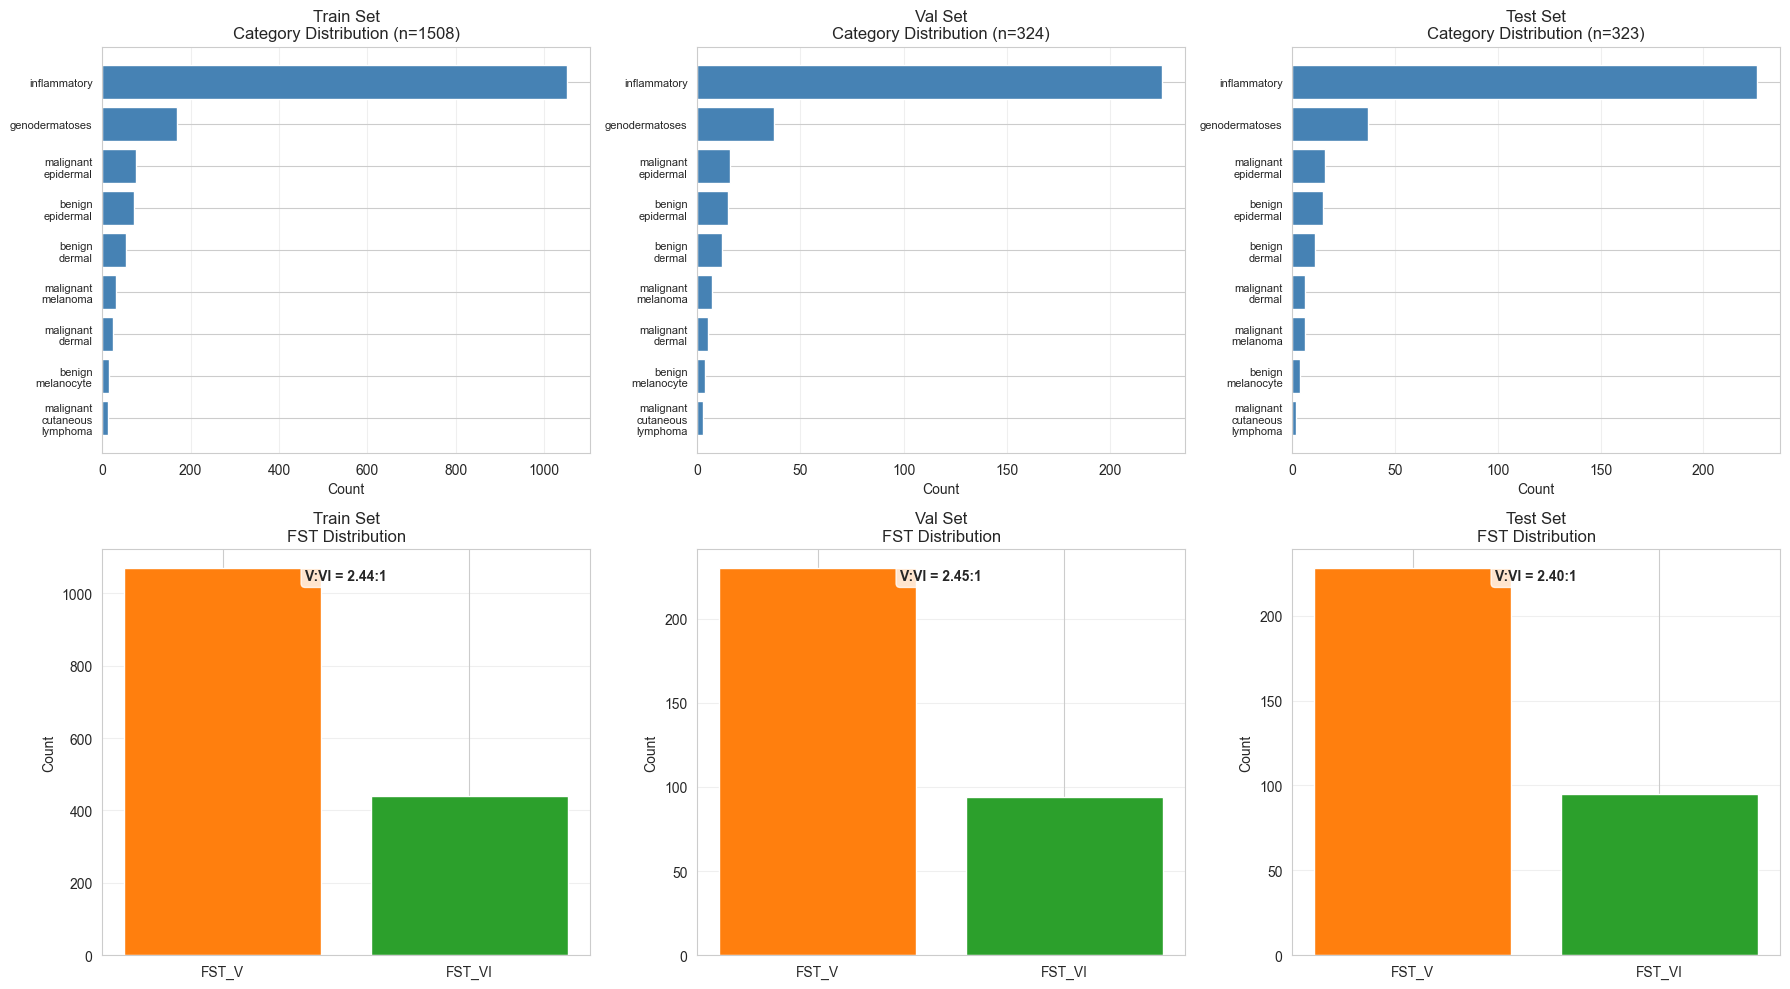


Visualization saved to: ../results/augmentation/split_distributions.png


In [18]:
# Visualize split distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Category distributions
for idx, (split_df, split_name) in enumerate([(train_df, 'Train'), (val_df, 'Val'), (test_df, 'Test')]):
    cat_dist = split_df['nine_partition_label'].value_counts().sort_values(ascending=True)
    axes[0, idx].barh(range(len(cat_dist)), cat_dist.values, color='steelblue')
    axes[0, idx].set_yticks(range(len(cat_dist)))
    axes[0, idx].set_yticklabels([label.replace(' ', '\n') for label in cat_dist.index], fontsize=8)
    axes[0, idx].set_xlabel('Count')
    axes[0, idx].set_title(f'{split_name} Set\nCategory Distribution (n={len(split_df)})')
    axes[0, idx].grid(axis='x', alpha=0.3)

# FST distributions
for idx, (split_df, split_name) in enumerate([(train_df, 'Train'), (val_df, 'Val'), (test_df, 'Test')]):
    fst_dist = split_df['fst_label'].value_counts()
    axes[1, idx].bar(fst_dist.index, fst_dist.values, color=['#FF7F0E', '#2CA02C'])
    axes[1, idx].set_ylabel('Count')
    axes[1, idx].set_title(f'{split_name} Set\nFST Distribution')
    axes[1, idx].grid(axis='y', alpha=0.3)
    
    # Add ratio text
    if len(fst_dist) == 2:
        ratio = fst_dist.get('FST_V', 0) / fst_dist.get('FST_VI', 1)
        axes[1, idx].text(0.5, 0.95, f'V:VI = {ratio:.2f}:1', 
                         transform=axes[1, idx].transAxes,
                         ha='center', va='top', fontsize=10, fontweight='bold',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'split_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to:", RESULTS_DIR / 'split_distributions.png')

## 4. Copy Original Images to Processed Directories

Organize images in PyTorch ImageFolder structure: `split/category/images/`

In [19]:
def copy_images_to_split(split_df, split_name, base_dir, resize=True, target_size=IMAGE_SIZE):
    """
    Copy and optionally resize images to the split directory.
    
    Args:
        split_df: DataFrame with image metadata
        split_name: 'train', 'val', or 'test'
        base_dir: Base directory for the split
        resize: Whether to resize images
        target_size: Target size for resizing (width, height)
    """
    print(f"\nProcessing {split_name} set...")
    
    split_dir = base_dir / split_name
    copied_count = 0
    error_count = 0
    
    for idx, row in split_df.iterrows():
        category = row['nine_partition_label']
        source_path = row['image_path']
        
        # Create category directory
        category_dir = split_dir / category / 'images'
        category_dir.mkdir(parents=True, exist_ok=True)
        
        # Destination path
        dest_path = category_dir / f"{row['md5hash']}.jpg"
        
        try:
            if resize:
                # Open, resize, and save image
                img = Image.open(source_path).convert('RGB')
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img.save(dest_path, IMAGE_FORMAT, quality=95)
            else:
                # Just copy the image
                shutil.copy2(source_path, dest_path)
            
            copied_count += 1
            
            if copied_count % 100 == 0:
                print(f"  Processed {copied_count}/{len(split_df)} images...", end='\r')
                
        except Exception as e:
            print(f"\nError processing {source_path}: {e}")
            error_count += 1
    
    print(f"\n  ✓ Copied {copied_count} images to {split_dir}")
    if error_count > 0:
        print(f"  ✗ Failed to copy {error_count} images")
    
    return copied_count, error_count

# Copy images for all splits
print("Copying images to processed directories...")
print("=" * 60)

train_copied, train_errors = copy_images_to_split(train_df, 'train', PROCESSED_DIR, resize=True)
val_copied, val_errors = copy_images_to_split(val_df, 'val', PROCESSED_DIR, resize=True)
test_copied, test_errors = copy_images_to_split(test_df, 'test', PROCESSED_DIR, resize=True)

print("\n" + "=" * 60)
print("SUMMARY:")
print(f"  Train: {train_copied} images copied")
print(f"  Val: {val_copied} images copied")
print(f"  Test: {test_copied} images copied")
print(f"  Total: {train_copied + val_copied + test_copied} images")
print("=" * 60)

Copying images to processed directories...

Processing train set...
  Processed 1500/1508 images...
  ✓ Copied 1508 images to ../data/processed/fst_v_vi/train

Processing val set...
  Processed 300/324 images...
  ✓ Copied 324 images to ../data/processed/fst_v_vi/val

Processing test set...
  Processed 300/323 images...
  ✓ Copied 323 images to ../data/processed/fst_v_vi/test

SUMMARY:
  Train: 1508 images copied
  Val: 324 images copied
  Test: 323 images copied
  Total: 2155 images


## 5. Generate Augmentation Strategy

Define augmentation strategy based on the actual training split.
This ensures the strategy is reproducible and tied to the training data.

In [20]:
# Analyze training set class distribution
train_category_counts = train_df['nine_partition_label'].value_counts().sort_values(ascending=False)

print("="*60)
print("TRAINING SET CLASS DISTRIBUTION")
print("="*60)
print(train_category_counts)
print(f"\nMax class: {train_category_counts.max()} samples")
print(f"Min class: {train_category_counts.min()} samples")
print(f"Imbalance ratio: {train_category_counts.max() / train_category_counts.min():.2f}:1")

TRAINING SET CLASS DISTRIBUTION
nine_partition_label
inflammatory                    1051
genodermatoses                   170
malignant epidermal               76
benign epidermal                  72
benign dermal                     54
malignant melanoma                32
malignant dermal                  25
benign melanocyte                 16
malignant cutaneous lymphoma      12
Name: count, dtype: int64

Max class: 1051 samples
Min class: 12 samples
Imbalance ratio: 87.58:1


In [21]:
# Define augmentation strategy with conservative targets
# Rules:
# - Target range: 200-300 samples for minority classes
# - Do not augment dominant class (inflammatory)
# - Do not augment classes already >= 200 samples
# - Conservative caps for ultra-rare classes

TARGET_MIN = 200
TARGET_MAX = 300

aug_strategy_data = []

for category, current_count in train_category_counts.items():
    # Skip inflammatory (dominant class)
    if category == 'inflammatory':
        target = current_count
        needed = 0
        factor = 1.0
    # Skip genodermatoses (second largest, already well-represented)
    elif category == 'genodermatoses':
        target = current_count
        needed = 0
        factor = 1.0
    # Classes with < 100 samples: conservative augmentation
    elif current_count < 100:
        # Cap at 200 for very rare classes
        target = TARGET_MIN
        needed = max(0, target - current_count)
        factor = target / current_count if current_count > 0 else 1.0
    # Classes with 100-199 samples: augment to 250
    elif current_count < TARGET_MIN:
        target = 250
        needed = max(0, target - current_count)
        factor = target / current_count if current_count > 0 else 1.0
    # Classes already >= 200: no augmentation needed
    else:
        target = current_count
        needed = 0
        factor = 1.0
    
    aug_strategy_data.append({
        'category': category,
        'current_samples': int(current_count),
        'target_samples': int(target),
        'augmentation_needed': int(needed),
        'augmentation_factor': round(factor, 1)
    })

# Create augmentation strategy dataframe
aug_strategy = pd.DataFrame(aug_strategy_data)
aug_strategy = aug_strategy.sort_values('current_samples', ascending=True)

print("\n" + "="*60)
print("AUGMENTATION STRATEGY (GENERATED)")
print("="*60)
print(aug_strategy.to_string(index=False))

# Save strategy for reference
aug_strategy.to_csv(RESULTS_DIR / 'augmentation_strategy_STAGE1.csv', index=False)
print(f"\n✓ Strategy saved to: {RESULTS_DIR / 'augmentation_strategy_STAGE1.csv'}")

# Filter only categories that need augmentation
categories_to_augment = aug_strategy[aug_strategy['augmentation_needed'] > 0]['category'].tolist()

print(f"\n✓ Categories requiring augmentation: {len(categories_to_augment)}")
print(categories_to_augment)


AUGMENTATION STRATEGY (GENERATED)
                    category  current_samples  target_samples  augmentation_needed  augmentation_factor
malignant cutaneous lymphoma               12             200                  188                 16.7
           benign melanocyte               16             200                  184                 12.5
            malignant dermal               25             200                  175                  8.0
          malignant melanoma               32             200                  168                  6.2
               benign dermal               54             200                  146                  3.7
            benign epidermal               72             200                  128                  2.8
         malignant epidermal               76             200                  124                  2.6
              genodermatoses              170             170                    0                  1.0
                inflammatory 

In [22]:
# Create augmentation requirements dictionary
aug_requirements = {}
for _, row in aug_strategy.iterrows():
    if row['augmentation_needed'] > 0:
        aug_requirements[row['category']] = {
            'current': int(row['current_samples']),
            'target': int(row['target_samples']),
            'needed': int(row['augmentation_needed']),
            'factor': float(row['augmentation_factor'])
        }

print("\n" + "="*60)
print("AUGMENTATION REQUIREMENTS SUMMARY")
print("="*60)
for cat, req in aug_requirements.items():
    print(f"\n{cat}:")
    print(f"  Current (training set): {req['current']}")
    print(f"  Target: {req['target']}")
    print(f"  Additional needed: {req['needed']}")
    print(f"  Augmentation factor: {req['factor']:.1f}x")


AUGMENTATION REQUIREMENTS SUMMARY

malignant cutaneous lymphoma:
  Current (training set): 12
  Target: 200
  Additional needed: 188
  Augmentation factor: 16.7x

benign melanocyte:
  Current (training set): 16
  Target: 200
  Additional needed: 184
  Augmentation factor: 12.5x

malignant dermal:
  Current (training set): 25
  Target: 200
  Additional needed: 175
  Augmentation factor: 8.0x

malignant melanoma:
  Current (training set): 32
  Target: 200
  Additional needed: 168
  Augmentation factor: 6.2x

benign dermal:
  Current (training set): 54
  Target: 200
  Additional needed: 146
  Augmentation factor: 3.7x

benign epidermal:
  Current (training set): 72
  Target: 200
  Additional needed: 128
  Augmentation factor: 2.8x

malignant epidermal:
  Current (training set): 76
  Target: 200
  Additional needed: 124
  Augmentation factor: 2.6x


## 6. Setup Augmentation Pipeline

We'll use albumentations for realistic, clinically-appropriate augmentation.

In [23]:
# Check if albumentations is installed
try:
    import albumentations as A
    print("✓ albumentations is installed")
    USE_ALBUMENTATIONS = True
except ImportError:
    print("✗ albumentations not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'albumentations', '--quiet'])
    import albumentations as A
    print("✓ albumentations installed successfully")
    USE_ALBUMENTATIONS = True

✗ albumentations not found. Installing...
✓ albumentations installed successfully


In [24]:
# Define augmentation pipeline (mild, realistic transformations)
augmentation_pipeline = A.Compose([
    A.OneOf([
        A.Rotate(limit=15, p=1.0),  # ±15 degrees rotation
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.8),
    
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=1.0),
    ], p=0.7),
    
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 30.0), p=1.0),
        A.Blur(blur_limit=3, p=1.0),
    ], p=0.3),
])

# Create individual augmentation techniques for visualization
aug_techniques = {
    'rotation': A.Rotate(limit=15, p=1.0),
    'horizontal_flip': A.HorizontalFlip(p=1.0),
    'brightness': A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
    'zoom': A.ShiftScaleRotate(shift_limit=0, scale_limit=0.1, rotate_limit=0, p=1.0),
    'shift': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=1.0),
}

print("Augmentation pipeline configured with:")
print("  - Rotation (±15°)")
print("  - Horizontal/Vertical flips")
print("  - Brightness adjustment (±15%)")
print("  - Zoom (0.9-1.1×)")
print("  - Width/height shift (±10%)")
print("  - Mild noise and blur (occasional)")

Augmentation pipeline configured with:
  - Rotation (±15°)
  - Horizontal/Vertical flips
  - Brightness adjustment (±15%)
  - Zoom (0.9-1.1×)
  - Width/height shift (±10%)
  - Mild noise and blur (occasional)


## 7. Perform Targeted Augmentation

Apply augmentation **only** to selected minority categories in the training set, preserving FST subgroups.

In [25]:
def augment_category_by_fst(category, train_df, aug_requirements, output_dir, augmentation_fn):
    """
    Augment images for a specific category, maintaining FST distribution.
    
    Args:
        category: Category name to augment
        train_df: Training dataframe
        aug_requirements: Dictionary with augmentation requirements
        output_dir: Output directory for augmented images
        augmentation_fn: Augmentation function to apply
    
    Returns:
        augmented_count: Number of augmented images created
    """
    # Filter training data for this category
    cat_df = train_df[train_df['nine_partition_label'] == category].copy()
    
    if category not in aug_requirements:
        return 0
    
    req = aug_requirements[category]
    current_train_count = len(cat_df)
    
    # Use the target directly (strategy was generated from training set)
    target_count = req['target']
    needed_count = req['needed']
    
    print(f"\n{'='*60}")
    print(f"Augmenting: {category}")
    print(f"{'='*60}")
    print(f"  Current in train set: {current_train_count}")
    print(f"  Target: {target_count}")
    print(f"  Additional images needed: {needed_count}")
    
    if needed_count == 0:
        print("  → No augmentation needed (target already met)")
        return 0
    
    # Create output directory
    category_output_dir = output_dir / category / 'images'
    category_output_dir.mkdir(parents=True, exist_ok=True)
    
    # First, copy original images
    print(f"\n  Copying {current_train_count} original images...")
    for _, row in cat_df.iterrows():
        source_path = PROCESSED_DIR / 'train' / category / 'images' / f"{row['md5hash']}.jpg"
        dest_path = category_output_dir / f"{row['md5hash']}.jpg"
        shutil.copy2(source_path, dest_path)
    
    # Get FST distribution in this category
    fst_counts = cat_df['fst_label'].value_counts()
    print(f"\n  FST distribution: {dict(fst_counts)}")
    
    # Calculate how many augmentations needed per FST group (proportional)
    fst_proportions = fst_counts / fst_counts.sum()
    fst_targets = {}
    for fst, prop in fst_proportions.items():
        fst_targets[fst] = int(needed_count * prop)
    
    print(f"  Augmentation targets per FST: {fst_targets}")
    
    # Perform augmentation for each FST group
    total_augmented = 0
    augmented_metadata = []
    
    for fst_label, target_aug in fst_targets.items():
        if target_aug == 0:
            continue
            
        fst_images = cat_df[cat_df['fst_label'] == fst_label]
        print(f"\n  Processing {fst_label} (target: {target_aug} augmentations)...")
        
        aug_count = 0
        while aug_count < target_aug:
            # Randomly select an image from this FST group
            row = fst_images.sample(n=1, random_state=RANDOM_SEED + aug_count).iloc[0]
            source_path = PROCESSED_DIR / 'train' / category / 'images' / f"{row['md5hash']}.jpg"
            
            # Load and augment image
            img = Image.open(source_path).convert('RGB')
            img_array = np.array(img)
            
            # Apply augmentation
            augmented = augmentation_fn(image=img_array)
            aug_img = Image.fromarray(augmented['image'])
            
            # Save augmented image
            aug_filename = f"{row['md5hash']}_aug_{aug_count:04d}.jpg"
            aug_path = category_output_dir / aug_filename
            aug_img.save(aug_path, IMAGE_FORMAT, quality=95)
            
            augmented_metadata.append({
                'original_md5': row['md5hash'],
                'augmented_filename': aug_filename,
                'category': category,
                'fst_label': fst_label,
                'fst_scale': row['fitzpatrick_scale']
            })
            
            aug_count += 1
            total_augmented += 1
            
            if aug_count % 20 == 0:
                print(f"    Generated {aug_count}/{target_aug} augmentations...", end='\r')
        
        print(f"    ✓ Generated {aug_count} augmentations for {fst_label}")
    
    print(f"\n  ✓ Total augmented images created: {total_augmented}")
    print(f"  ✓ Final count (original + augmented): {current_train_count + total_augmented}")
    
    return total_augmented, augmented_metadata

print("Augmentation function defined.")

Augmentation function defined.


In [26]:
# Apply augmentation to all target categories
print("\n" + "="*60)
print("STARTING TARGETED AUGMENTATION")
print("="*60)

augmentation_summary = []
all_augmented_metadata = []

for category in categories_to_augment:
    aug_count, aug_metadata = augment_category_by_fst(
        category=category,
        train_df=train_df,
        aug_requirements=aug_requirements,
        output_dir=AUGMENTED_DIR / 'train_augmented',
        augmentation_fn=augmentation_pipeline
    )
    
    original_count = len(train_df[train_df['nine_partition_label'] == category])
    
    augmentation_summary.append({
        'category': category,
        'original_train_count': original_count,
        'augmented_count': aug_count,
        'final_count': original_count + aug_count
    })
    
    all_augmented_metadata.extend(aug_metadata)

print("\n" + "="*60)
print("AUGMENTATION COMPLETE")
print("="*60)


STARTING TARGETED AUGMENTATION

Augmenting: malignant cutaneous lymphoma
  Current in train set: 12
  Target: 200
  Additional images needed: 188

  Copying 12 original images...

  FST distribution: {'FST_V': np.int64(10), 'FST_VI': np.int64(2)}
  Augmentation targets per FST: {'FST_V': 156, 'FST_VI': 31}

  Processing FST_V (target: 156 augmentations)...
    ✓ Generated 156 augmentations for FST_V

  Processing FST_VI (target: 31 augmentations)...
    ✓ Generated 31 augmentations for FST_VI

  ✓ Total augmented images created: 187
  ✓ Final count (original + augmented): 199

Augmenting: benign melanocyte
  Current in train set: 16
  Target: 200
  Additional images needed: 184

  Copying 16 original images...

  FST distribution: {'FST_V': np.int64(12), 'FST_VI': np.int64(4)}
  Augmentation targets per FST: {'FST_V': 138, 'FST_VI': 46}

  Processing FST_V (target: 138 augmentations)...
    ✓ Generated 138 augmentations for FST_V

  Processing FST_VI (target: 46 augmentations)...
    

In [27]:
# Create summary dataframe
aug_summary_df = pd.DataFrame(augmentation_summary)

# Add non-augmented categories
for category in train_df['nine_partition_label'].unique():
    if category not in categories_to_augment:
        original_count = len(train_df[train_df['nine_partition_label'] == category])
        aug_summary_df = pd.concat([aug_summary_df, pd.DataFrame([{
            'category': category,
            'original_train_count': original_count,
            'augmented_count': 0,
            'final_count': original_count
        }])], ignore_index=True)

aug_summary_df = aug_summary_df.sort_values('final_count', ascending=False)

print("\nAugmentation Summary:")
print(aug_summary_df.to_string(index=False))

# Save summary
aug_summary_df.to_csv(RESULTS_DIR / 'augmentation_summary.csv', index=False)
print(f"\nSummary saved to: {RESULTS_DIR / 'augmentation_summary.csv'}")


Augmentation Summary:
                    category  original_train_count  augmented_count  final_count
                inflammatory                  1051                0         1051
           benign melanocyte                    16              184          200
            malignant dermal                    25              175          200
malignant cutaneous lymphoma                    12              187          199
          malignant melanoma                    32              167          199
               benign dermal                    54              145          199
            benign epidermal                    72              127          199
         malignant epidermal                    76              123          199
              genodermatoses                   170                0          170

Summary saved to: ../results/augmentation/augmentation_summary.csv


In [28]:
# Save augmented metadata
if all_augmented_metadata:
    aug_metadata_df = pd.DataFrame(all_augmented_metadata)
    aug_metadata_df.to_csv(RESULTS_DIR / 'augmented_images_metadata.csv', index=False)
    print(f"Augmented images metadata saved to: {RESULTS_DIR / 'augmented_images_metadata.csv'}")
    print(f"Total augmented images tracked: {len(aug_metadata_df)}")

Augmented images metadata saved to: ../results/augmentation/augmented_images_metadata.csv
Total augmented images tracked: 1108


## 8. Visualize Before/After Distributions

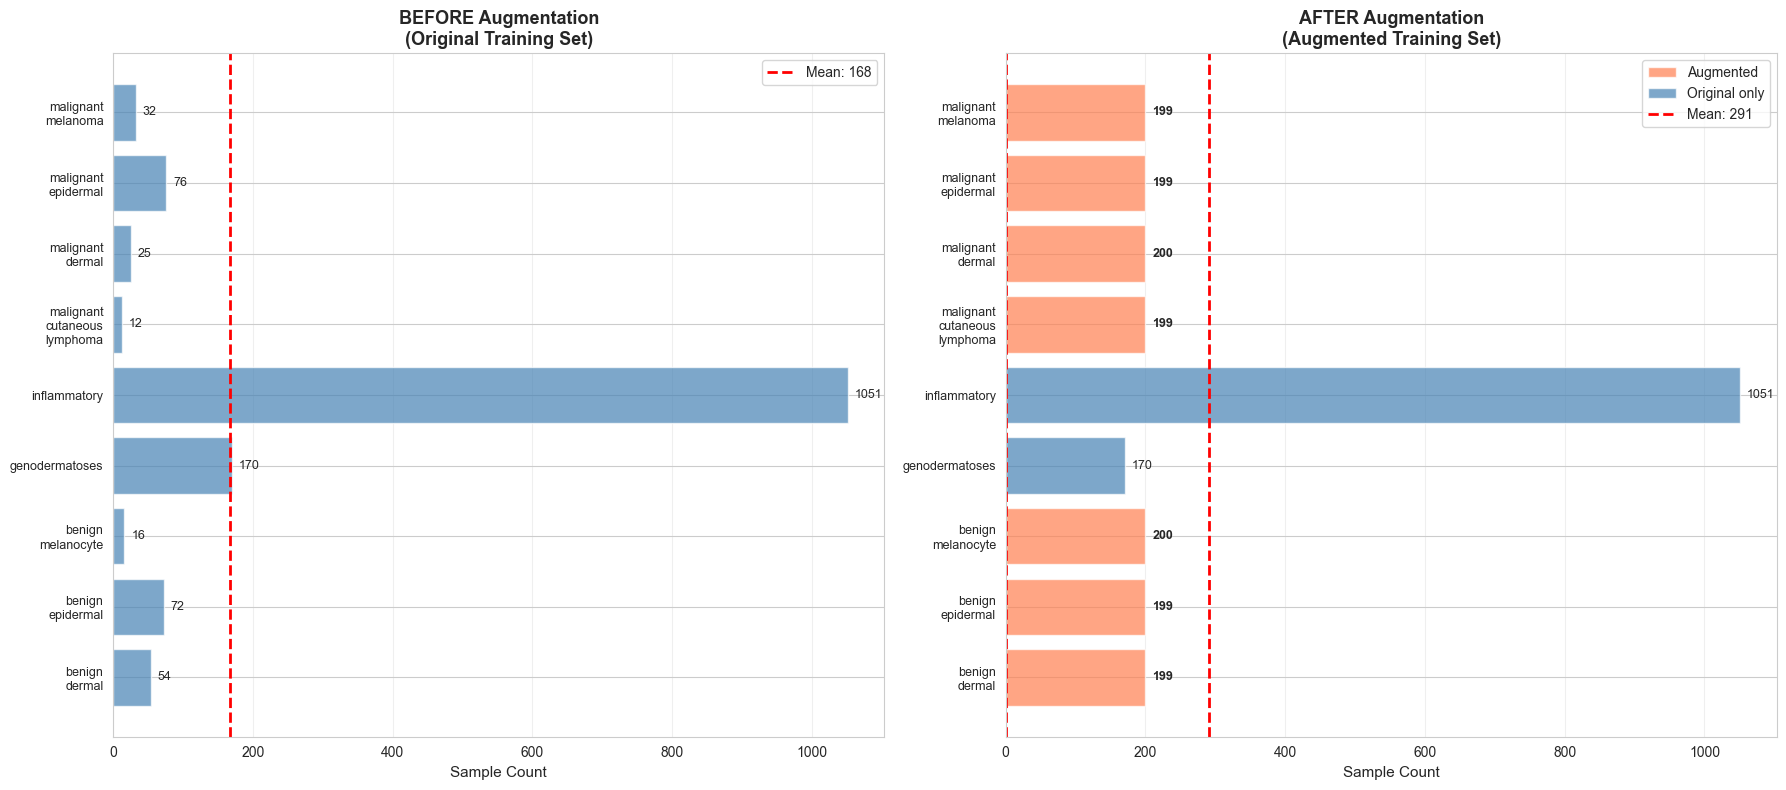


Visualization saved to: ../results/augmentation/before_after_augmentation.png


In [29]:
# Prepare data for visualization
before_counts = train_df['nine_partition_label'].value_counts().sort_index()
after_counts = aug_summary_df.set_index('category')['final_count'].sort_index()

# Ensure both have same categories
all_categories = sorted(train_df['nine_partition_label'].unique())
before_values = [before_counts.get(cat, 0) for cat in all_categories]
after_values = [after_counts.get(cat, 0) for cat in all_categories]

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Before augmentation
axes[0].barh(range(len(all_categories)), before_values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(all_categories)))
axes[0].set_yticklabels([cat.replace(' ', '\n') for cat in all_categories], fontsize=9)
axes[0].set_xlabel('Sample Count', fontsize=11)
axes[0].set_title('BEFORE Augmentation\n(Original Training Set)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=np.mean(before_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(before_values):.0f}')
axes[0].legend()

# Add values on bars
for i, v in enumerate(before_values):
    axes[0].text(v + 10, i, str(v), va='center', fontsize=9)

# After augmentation
colors = ['coral' if cat in categories_to_augment else 'steelblue' for cat in all_categories]
axes[1].barh(range(len(all_categories)), after_values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(all_categories)))
axes[1].set_yticklabels([cat.replace(' ', '\n') for cat in all_categories], fontsize=9)
axes[1].set_xlabel('Sample Count', fontsize=11)
axes[1].set_title('AFTER Augmentation\n(Augmented Training Set)', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=np.mean(after_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(after_values):.0f}')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='coral', alpha=0.7, label='Augmented'),
    Patch(facecolor='steelblue', alpha=0.7, label='Original only'),
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(after_values):.0f}')
]
axes[1].legend(handles=legend_elements)

# Add values on bars
for i, v in enumerate(after_values):
    axes[1].text(v + 10, i, str(v), va='center', fontsize=9, fontweight='bold' if colors[i]=='coral' else 'normal')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'before_after_augmentation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to:", RESULTS_DIR / 'before_after_augmentation.png')

In [30]:
# Calculate and display imbalance metrics
print("\n" + "="*60)
print("IMBALANCE ANALYSIS")
print("="*60)

# Before
before_max = max(before_values)
before_min = min(before_values)
before_ratio = before_max / before_min
before_std = np.std(before_values)
before_cv = before_std / np.mean(before_values)

print(f"\nBEFORE Augmentation:")
print(f"  Max class: {before_max} samples")
print(f"  Min class: {before_min} samples")
print(f"  Imbalance ratio: {before_ratio:.2f}:1")
print(f"  Std deviation: {before_std:.2f}")
print(f"  Coefficient of variation: {before_cv:.2f}")

# After
after_max = max(after_values)
after_min = min(after_values)
after_ratio = after_max / after_min
after_std = np.std(after_values)
after_cv = after_std / np.mean(after_values)

print(f"\nAFTER Augmentation:")
print(f"  Max class: {after_max} samples")
print(f"  Min class: {after_min} samples")
print(f"  Imbalance ratio: {after_ratio:.2f}:1")
print(f"  Std deviation: {after_std:.2f}")
print(f"  Coefficient of variation: {after_cv:.2f}")

print(f"\nIMPROVEMENT:")
print(f"  Imbalance reduction: {(1 - after_ratio/before_ratio)*100:.1f}%")
print(f"  Std deviation reduction: {(1 - after_std/before_std)*100:.1f}%")
print(f"  CV reduction: {(1 - after_cv/before_cv)*100:.1f}%")


IMBALANCE ANALYSIS

BEFORE Augmentation:
  Max class: 1051 samples
  Min class: 12 samples
  Imbalance ratio: 87.58:1
  Std deviation: 315.66
  Coefficient of variation: 1.88

AFTER Augmentation:
  Max class: 1051 samples
  Min class: 170 samples
  Imbalance ratio: 6.18:1
  Std deviation: 268.97
  Coefficient of variation: 0.93

IMPROVEMENT:
  Imbalance reduction: 92.9%
  Std deviation reduction: 14.8%
  CV reduction: 50.9%


## 9. Visualize Sample Augmentations

Show examples of augmented images for each augmented category.

Creating augmentation visualizations...

Generating visualization for: malignant cutaneous lymphoma


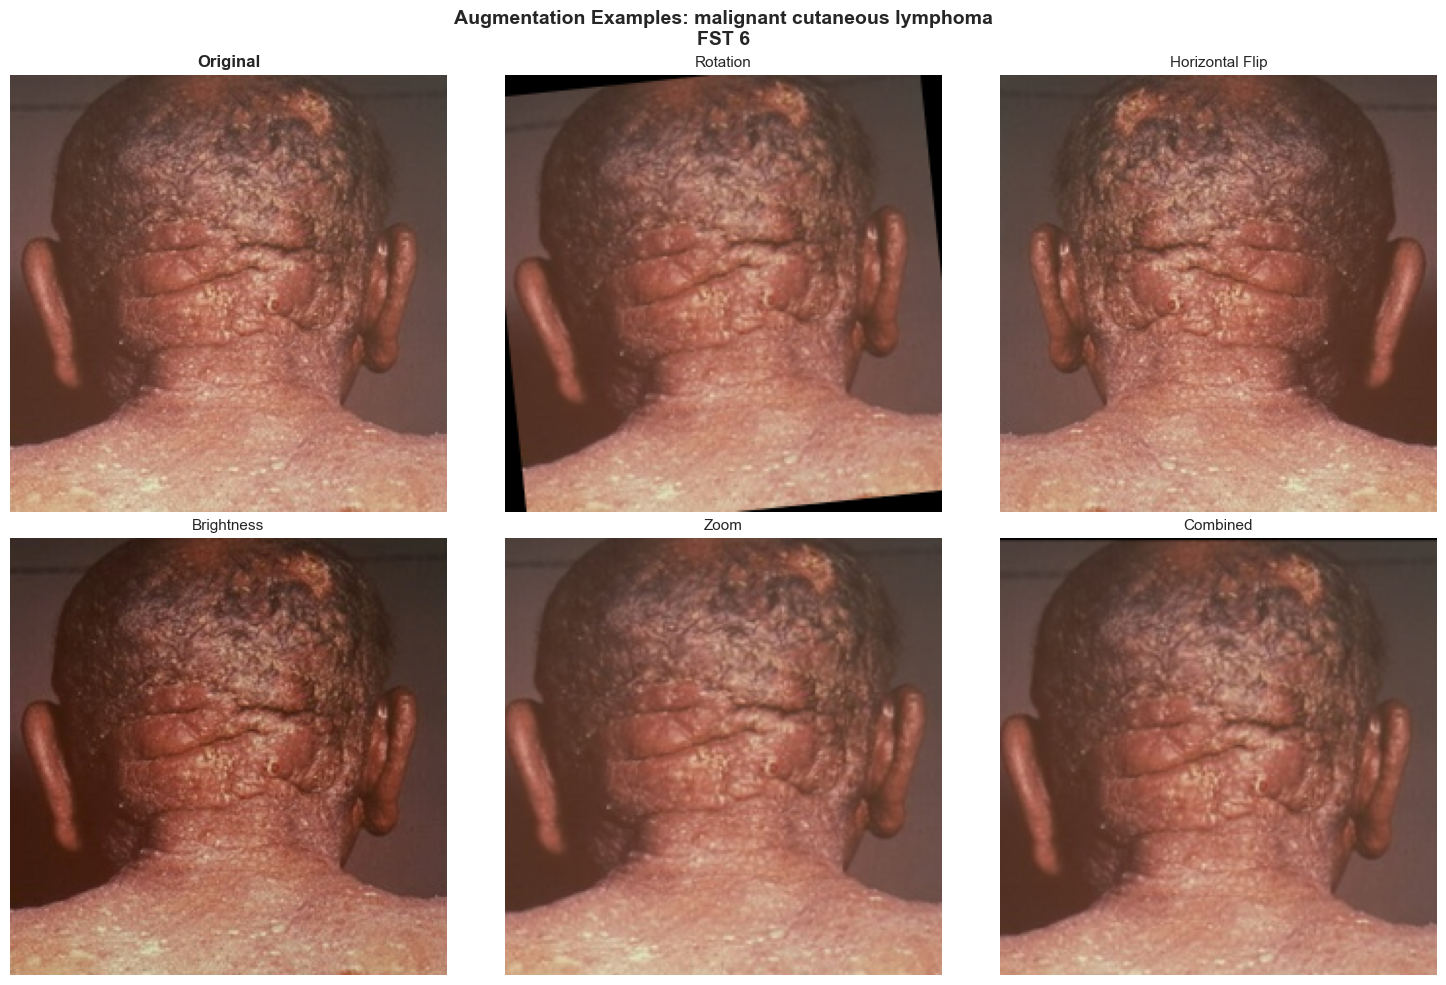

  ✓ Saved to: augmentation_samples_malignant_cutaneous_lymphoma.png

Generating visualization for: benign melanocyte


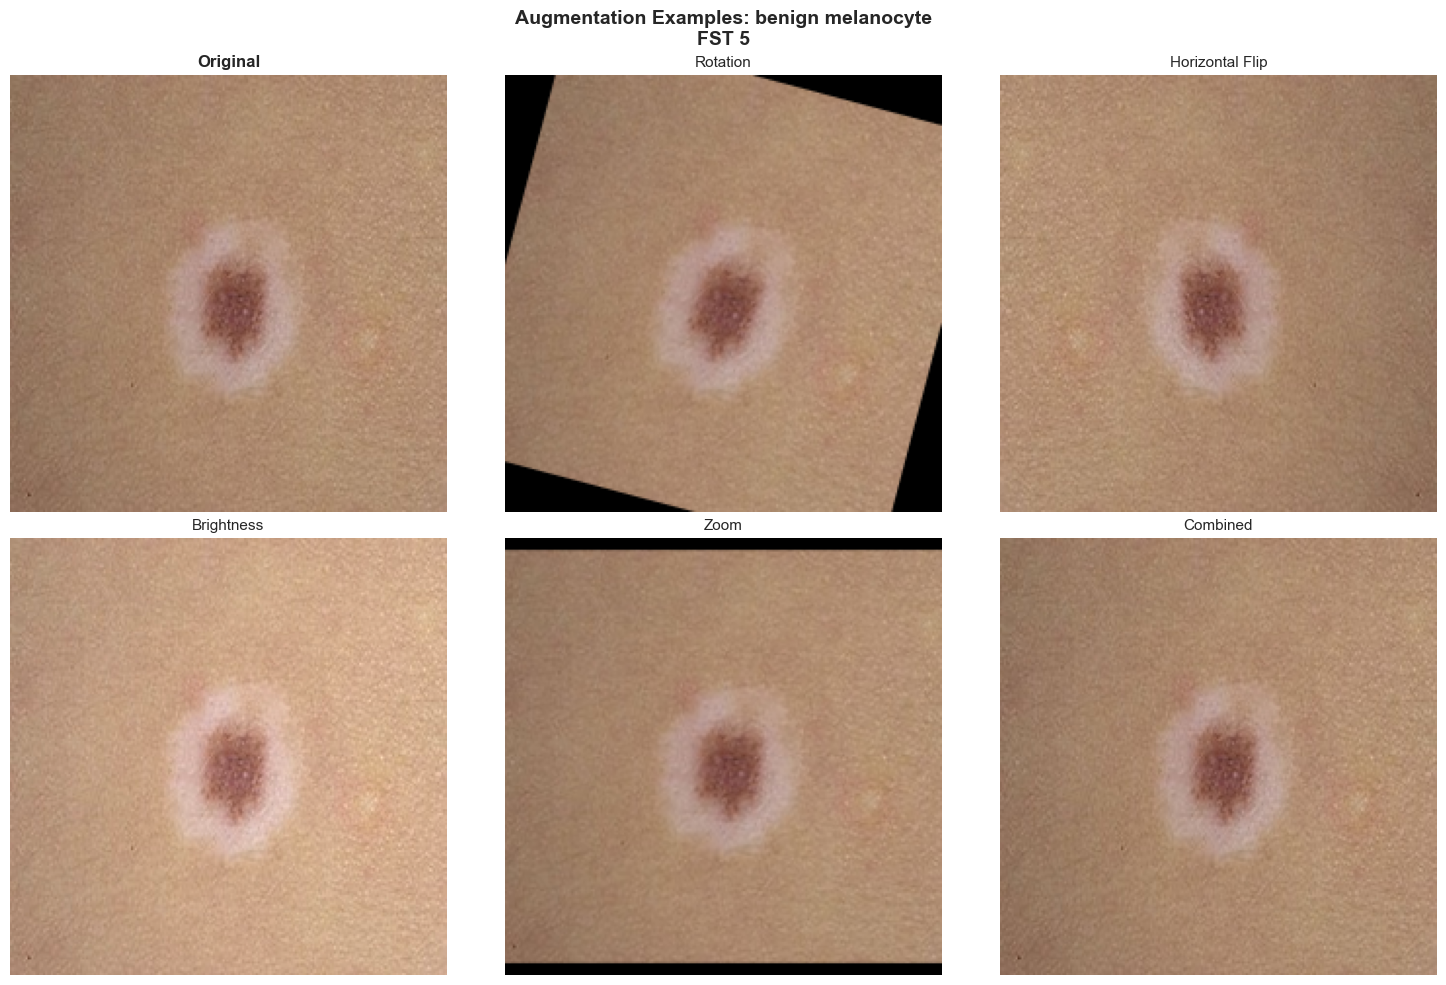

  ✓ Saved to: augmentation_samples_benign_melanocyte.png

Generating visualization for: malignant dermal


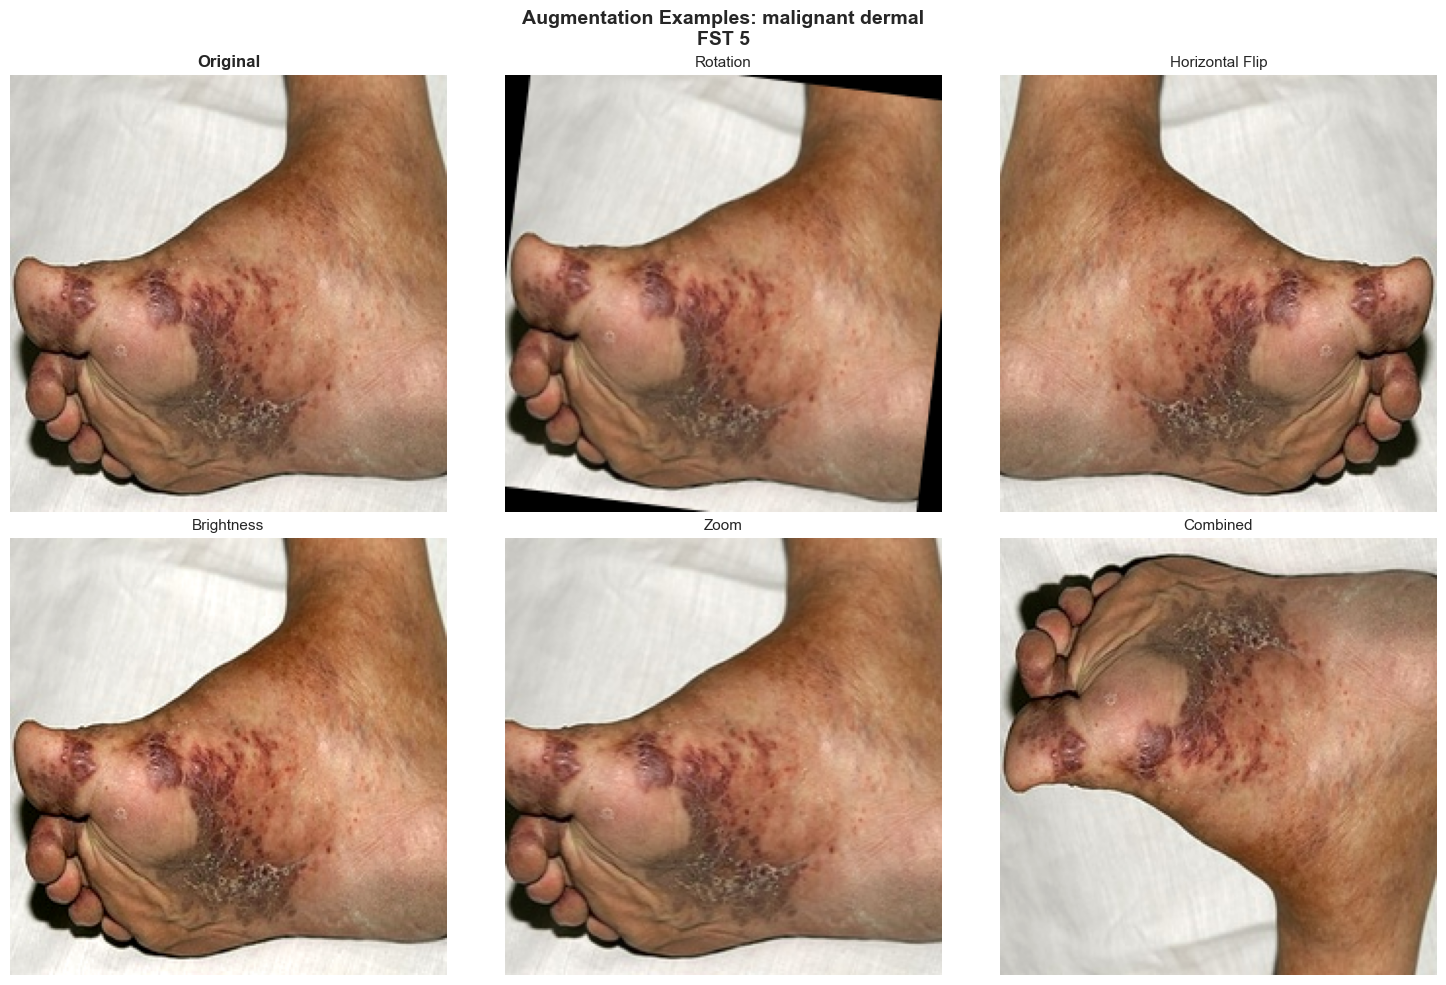

  ✓ Saved to: augmentation_samples_malignant_dermal.png



In [31]:
def visualize_augmentation_samples(category, n_samples=5):
    """
    Visualize original image and its augmented versions.
    """
    # Get a sample original image from train set
    cat_df = train_df[train_df['nine_partition_label'] == category]
    if len(cat_df) == 0:
        print(f"No images found for category: {category}")
        return
    
    sample_row = cat_df.sample(n=1, random_state=RANDOM_SEED).iloc[0]
    original_path = PROCESSED_DIR / 'train' / category / 'images' / f"{sample_row['md5hash']}.jpg"
    
    # Load original image
    original_img = Image.open(original_path).convert('RGB')
    original_array = np.array(original_img)
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Augmentation Examples: {category}\nFST {sample_row["fitzpatrick_scale"]}', 
                 fontsize=14, fontweight='bold')
    
    # Show original
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Apply and show augmentations
    aug_names = ['Rotation', 'Horizontal Flip', 'Brightness', 'Zoom', 'Combined']
    aug_pipelines = [
        aug_techniques['rotation'],
        aug_techniques['horizontal_flip'],
        aug_techniques['brightness'],
        aug_techniques['zoom'],
        augmentation_pipeline
    ]
    
    positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
    
    for (row, col), name, pipeline in zip(positions, aug_names, aug_pipelines):
        augmented = pipeline(image=original_array)
        aug_img = augmented['image']
        
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(name, fontsize=11)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    return fig

# Create visualizations for each augmented category
print("Creating augmentation visualizations...\n")

for category in categories_to_augment[:3]:  # Show first 3 augmented categories
    print(f"Generating visualization for: {category}")
    fig = visualize_augmentation_samples(category)
    
    if fig is not None:
        # Save figure
        safe_name = category.replace(' ', '_')
        fig.savefig(RESULTS_DIR / f'augmentation_samples_{safe_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Saved to: augmentation_samples_{safe_name}.png\n")

## 10. Quality Validation

Verify data quality and ensure no leakage between splits.

In [32]:
print("="*60)
print("QUALITY VALIDATION")
print("="*60)

# 1. Check for data leakage (no overlapping md5 hashes)
print("\n1. Checking for data leakage...")

train_hashes = set(train_df['md5hash'])
val_hashes = set(val_df['md5hash'])
test_hashes = set(test_df['md5hash'])

train_val_overlap = train_hashes & val_hashes
train_test_overlap = train_hashes & test_hashes
val_test_overlap = val_hashes & test_hashes

if not train_val_overlap and not train_test_overlap and not val_test_overlap:
    print("  ✓ No data leakage detected - all splits are disjoint")
else:
    print("  ✗ WARNING: Data leakage detected!")
    if train_val_overlap:
        print(f"    Train-Val overlap: {len(train_val_overlap)} images")
    if train_test_overlap:
        print(f"    Train-Test overlap: {len(train_test_overlap)} images")
    if val_test_overlap:
        print(f"    Val-Test overlap: {len(val_test_overlap)} images")

QUALITY VALIDATION

1. Checking for data leakage...
  ✓ No data leakage detected - all splits are disjoint


In [33]:
# 2. Verify FST distribution preservation
print("\n2. Verifying FST distribution preservation...")

original_fst_ratio = df['fst_label'].value_counts()
original_ratio = original_fst_ratio['FST_V'] / original_fst_ratio['FST_VI']

train_fst_ratio = train_df['fst_label'].value_counts()
val_fst_ratio = val_df['fst_label'].value_counts()
test_fst_ratio = test_df['fst_label'].value_counts()

train_ratio = train_fst_ratio['FST_V'] / train_fst_ratio['FST_VI']
val_ratio = val_fst_ratio['FST_V'] / val_fst_ratio['FST_VI']
test_ratio = test_fst_ratio['FST_V'] / test_fst_ratio['FST_VI']

print(f"  Original FST V:VI ratio: {original_ratio:.2f}:1")
print(f"  Train FST V:VI ratio: {train_ratio:.2f}:1 (diff: {abs(train_ratio - original_ratio):.2f})")
print(f"  Val FST V:VI ratio: {val_ratio:.2f}:1 (diff: {abs(val_ratio - original_ratio):.2f})")
print(f"  Test FST V:VI ratio: {test_ratio:.2f}:1 (diff: {abs(test_ratio - original_ratio):.2f})")

max_diff = max(abs(train_ratio - original_ratio), abs(val_ratio - original_ratio), abs(test_ratio - original_ratio))
if max_diff < 0.1:
    print("  ✓ FST distribution well preserved across all splits")
elif max_diff < 0.2:
    print("  ⚠ FST distribution moderately preserved (acceptable)")
else:
    print("  ✗ WARNING: FST distribution not well preserved")


2. Verifying FST distribution preservation...
  Original FST V:VI ratio: 2.43:1
  Train FST V:VI ratio: 2.44:1 (diff: 0.00)
  Val FST V:VI ratio: 2.45:1 (diff: 0.02)
  Test FST V:VI ratio: 2.40:1 (diff: 0.03)
  ✓ FST distribution well preserved across all splits


In [34]:
# 3. Verify file counts
print("\n3. Verifying file counts...")

def count_images_in_dir(base_dir, split_name):
    total = 0
    split_dir = base_dir / split_name
    for category_dir in split_dir.iterdir():
        if category_dir.is_dir():
            images_dir = category_dir / 'images'
            if images_dir.exists():
                count = len(list(images_dir.glob('*.jpg')))
                total += count
    return total

train_processed_count = count_images_in_dir(PROCESSED_DIR, 'train')
val_processed_count = count_images_in_dir(PROCESSED_DIR, 'val')
test_processed_count = count_images_in_dir(PROCESSED_DIR, 'test')
train_augmented_count = count_images_in_dir(AUGMENTED_DIR, 'train_augmented')

print(f"  Processed train images: {train_processed_count} (expected: {len(train_df)})")
print(f"  Processed val images: {val_processed_count} (expected: {len(val_df)})")
print(f"  Processed test images: {test_processed_count} (expected: {len(test_df)})")
print(f"  Augmented train images: {train_augmented_count}")

expected_augmented = aug_summary_df['final_count'].sum()
print(f"    Expected augmented total: {expected_augmented}")

if (train_processed_count == len(train_df) and 
    val_processed_count == len(val_df) and 
    test_processed_count == len(test_df)):
    print("  ✓ All processed file counts match expectations")
else:
    print("  ✗ WARNING: File count mismatch detected")


3. Verifying file counts...
  Processed train images: 1508 (expected: 1508)
  Processed val images: 324 (expected: 324)
  Processed test images: 323 (expected: 323)
  Augmented train images: 1395
    Expected augmented total: 2616
  ✓ All processed file counts match expectations


In [35]:
# 4. Check image quality (random sample)
print("\n4. Checking image quality (random sample)...")

def check_image_quality(image_path):
    try:
        img = Image.open(image_path)
        width, height = img.size
        mode = img.mode
        return {
            'valid': True,
            'size': (width, height),
            'mode': mode
        }
    except Exception as e:
        return {
            'valid': False,
            'error': str(e)
        }

# Sample 20 random images from augmented directory
sample_images = []
for category in categories_to_augment[:2]:  # Check first 2 augmented categories
    category_dir = AUGMENTED_DIR / 'train_augmented' / category / 'images'
    if category_dir.exists():
        images = list(category_dir.glob('*_aug_*.jpg'))[:10]
        sample_images.extend(images)

quality_issues = 0
size_check = []

for img_path in sample_images:
    result = check_image_quality(img_path)
    if not result['valid']:
        print(f"  ✗ Quality issue: {img_path.name} - {result['error']}")
        quality_issues += 1
    else:
        size_check.append(result['size'])

if quality_issues == 0:
    print(f"  ✓ All {len(sample_images)} sampled images are valid")
    if size_check:
        unique_sizes = set(size_check)
        print(f"  Image sizes: {unique_sizes}")
else:
    print(f"  ✗ Found {quality_issues} quality issues")


4. Checking image quality (random sample)...
  ✓ All 20 sampled images are valid
  Image sizes: {(224, 224)}


## 11. Generate Final Report

In [36]:
# Create comprehensive report
report = {
    'dataset_info': {
        'total_images': len(df),
        'total_categories': df['nine_partition_label'].nunique(),
        'fst_distribution': dict(df['fst_label'].value_counts()),
        'fst_ratio': f"{original_ratio:.2f}:1"
    },
    'split_info': {
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df),
        'split_ratios': f"{TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}",
        'stratification': 'category + FST'
    },
    'augmentation_info': {
        'categories_augmented': len(categories_to_augment),
        'augmented_categories': categories_to_augment,
        'total_augmented_images': int(aug_summary_df['augmented_count'].sum()),
        'augmentation_techniques': [
            'Rotation (±15°)',
            'Horizontal/Vertical flip',
            'Brightness adjustment (±15%)',
            'Zoom (0.9-1.1×)',
            'Width/height shift (±10%)'
        ]
    },
    'class_distribution': {
        'before_augmentation': dict(train_df['nine_partition_label'].value_counts()),
        'after_augmentation': dict(aug_summary_df.set_index('category')['final_count'])
    },
    'imbalance_metrics': {
        'before': {
            'max_class': int(before_max),
            'min_class': int(before_min),
            'ratio': f"{before_ratio:.2f}:1",
            'std': float(before_std),
            'cv': float(before_cv)
        },
        'after': {
            'max_class': int(after_max),
            'min_class': int(after_min),
            'ratio': f"{after_ratio:.2f}:1",
            'std': float(after_std),
            'cv': float(after_cv)
        },
        'improvement': {
            'ratio_reduction_pct': float((1 - after_ratio/before_ratio)*100),
            'std_reduction_pct': float((1 - after_std/before_std)*100),
            'cv_reduction_pct': float((1 - after_cv/before_cv)*100)
        }
    },
    'validation': {
        'data_leakage': 'None detected',
        'fst_preservation': f"Max deviation: {max_diff:.2f}",
        'file_counts_match': True
    },
    'output_structure': {
        'processed_dir': str(PROCESSED_DIR),
        'augmented_dir': str(AUGMENTED_DIR / 'train_augmented'),
        'format': 'PyTorch ImageFolder (split/category/images/)'
    },
    'configuration': {
        'random_seed': RANDOM_SEED,
        'image_size': IMAGE_SIZE,
        'image_format': IMAGE_FORMAT
    }
}

# Save report as JSON
with open(RESULTS_DIR / 'augmentation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*60)
print("FINAL REPORT")
print("="*60)
print(json.dumps(report, indent=2))
print("\n" + "="*60)
print(f"Report saved to: {RESULTS_DIR / 'augmentation_report.json'}")
print("="*60)

TypeError: Object of type int64 is not JSON serializable

## 12. Summary & Next Steps

In [ ]:
print("\n" + "="*60)
print("DATA AUGMENTATION COMPLETE")
print("="*60)

print("\n✅ COMPLETED TASKS:")
print("  1. Stratified 70/15/15 split (preserving category + FST)")
print("  2. Targeted augmentation of minority classes in training set")
print("  3. Quality validation (no leakage, FST preservation)")
print("  4. Dataset organization in PyTorch ImageFolder structure")

print("\n📊 KEY METRICS:")
print(f"  • Total images: {len(df)}")
print(f"  • Train: {len(train_df)} → {aug_summary_df['final_count'].sum()} (after augmentation)")
print(f"  • Val: {len(val_df)}")
print(f"  • Test: {len(test_df)}")
print(f"  • Categories augmented: {len(categories_to_augment)}/9")
print(f"  • Imbalance reduction: {(1 - after_ratio/before_ratio)*100:.1f}%")

print("\n📁 OUTPUT DIRECTORIES:")
print(f"  • Original splits: {PROCESSED_DIR}")
print(f"  • Augmented train: {AUGMENTED_DIR / 'train_augmented'}")
print(f"  • Results: {RESULTS_DIR}")

print("\n🎯 NEXT STEPS:")
print("  1. Review augmentation quality visually")
print("  2. Proceed to model training (03_model_training.ipynb)")
print("  3. Use augmented training set for Stage 1 classifier")
print("  4. Validate on held-out val set during training")
print("  5. Final evaluation on test set")

print("\n" + "="*60)